In [31]:
import igraph as ig
import pandas as pd
import glob
import os
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [78]:
### Función para calcular las métricas de un grafo

def calcular_metricas(grafo, bip_num_nodes, simple_num_edges):
    num_nodes = abs(grafo.vcount() - bip_num_nodes)
    num_edges = abs(grafo.ecount() - simple_num_edges)
    densidad = grafo.density()
    modularidad = grafo.community_multilevel().modularity
    grado_promedio = sum(grafo.degree()) / grafo.vcount() if grafo.vcount() > 0 else 0
    
    # Si el grafo contiene una o más 
    if grafo.is_connected():
        distancia_promedio = grafo.average_path_length()
    else:
        # Encontrar el componente más grande
        componentes = grafo.decompose()
        if(len(componentes)) < 1:
            distancia_promedio = 0
        else:
            componente_mas_grande = max(componentes, key=lambda c: c.vcount())
            distancia_promedio = componente_mas_grande.average_path_length()
    
    num_componentes = len(grafo.components())
    coeficiente_clustering = grafo.transitivity_undirected()
    
    return {
        "n nodes": num_nodes,
        "n edges": num_edges,
        "Densidad": densidad,
        "Modularidad": modularidad,
        "Grado Promedio": grado_promedio,
        "Distancia Promedio": distancia_promedio,
        "Número de Componentes": num_componentes,
        "Coeficiente de Clustering": coeficiente_clustering
    }

def simple_projection(bigraph, typen=True):
    if typen:
        return bigraph.bipartite_projection(which=typen)
    else:
        return bigraph.bipartite_projection(which=typen)

In [95]:
##### **** Variables selection **** #####
DATASET = "AMZ"
DATASET_PATH = "01-AMZ"
TOPNODE = True

if TOPNODE:
    DIRPATH = "../00-Data/"+DATASET_PATH+"/02-Graphs/01-Top/"
else:
    DIRPATH = "../00-Data/"+DATASET_PATH+"/02-Graphs/02-Bot/"


bip_graph = ig.read("../00-Data/"+DATASET_PATH+"/02-Graphs/binet-"+DATASET+"-Rw.graphml")
bip_num_nodes = len(bip_graph.vs.select(type_eq=TOPNODE))
proj = simple_projection(bip_graph, TOPNODE)
edge_num_simple = proj.ecount()

# Ruta de la carpeta que contiene los archivos .graphml
archivos = glob.glob(os.path.join(DIRPATH, "*.graphml"))

In [96]:
# Lista para almacenar las métricas de cada grafo
metricas = []
flag_nodes_edges = True
# Procesar cada archivo .graphml
for archivo in archivos:
    g = ig.Graph.Read_GraphML(archivo)
    nombre_grafo = os.path.basename(archivo)
    metrica = calcular_metricas(g, bip_num_nodes, edge_num_simple)
    metrica["Grafo"] = nombre_grafo
    metricas.append(metrica)

# Crear un DataFrame con las métricas
df_metricas = pd.DataFrame(metricas)

# Guardar DF
if TOPNODE:
    df_metricas.to_csv("dfmetrics/DF-M-"+DATASET+"top.csv")
else:
    df_metricas.to_csv("dfmetrics/DF-M-"+DATASET+"bot.csv")

# Mostrar estadísticas descriptivas
print(df_metricas.describe())

# Excluir la columna no numérica ('Grafo') antes de calcular la correlación
correlacion = df_metricas.drop(columns=["Grafo"]).corr()
print("\nCorrelación entre métricas:")
print(correlacion)

df_metricas_numericas = df_metricas.drop(columns=["Grafo"])




           n nodes       n edges      Densidad  Modularidad  Grado Promedio  \
count    48.000000  4.800000e+01  4.800000e+01    48.000000       48.000000   
mean    156.166667  6.554083e+05  1.203456e-02     0.640935      111.859198   
std     394.921610  4.723956e+05  1.092886e-02     0.139967      101.609462   
min       1.000000  3.410000e+02  9.182319e-08     0.444352        0.000742   
25%       1.000000  2.185872e+05  7.292368e-05     0.552891        0.677607   
50%       1.000000  5.886465e+05  1.357661e-02     0.595598      126.208132   
75%       5.000000  1.172176e+06  2.214032e-02     0.706785      205.816446   
max    1214.000000  1.175322e+06  2.719086e-02     0.928482      252.766269   

       Distancia Promedio  Número de Componentes  Coeficiente de Clustering  
count           48.000000              48.000000                  47.000000  
mean             3.556436            3199.000000                   0.415701  
std              1.609853            3475.896052      

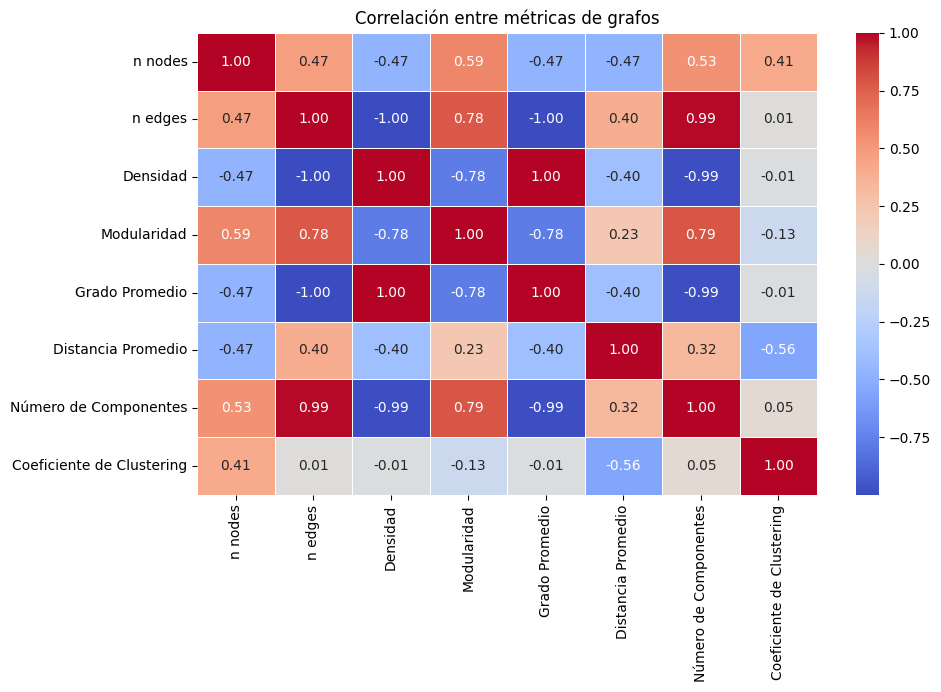

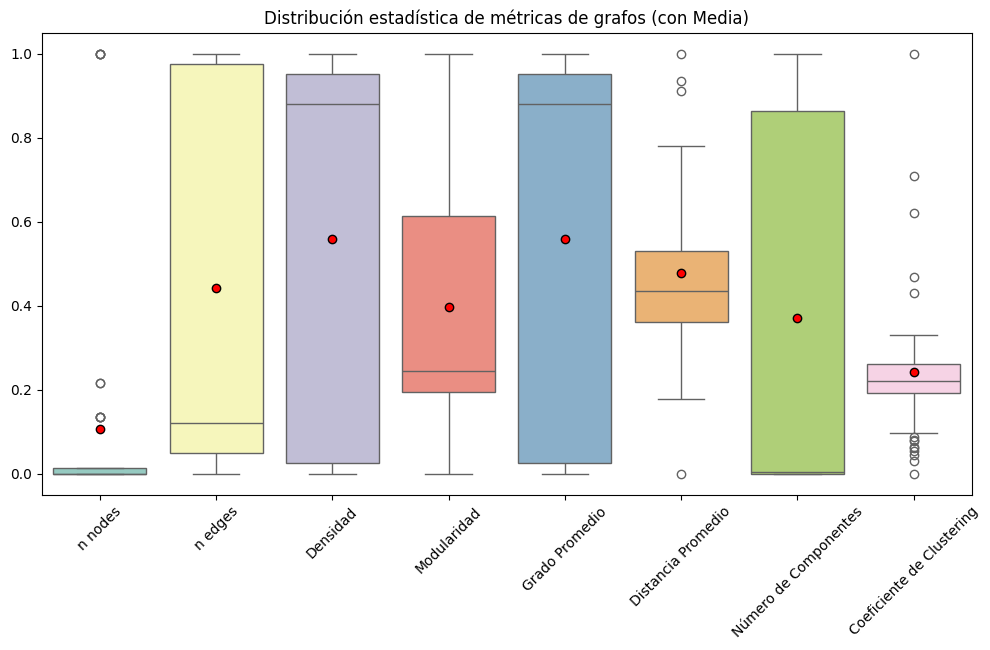

In [81]:
### Visualizar la matriz de correlación

plt.figure(figsize=(10, 6))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlación entre métricas de grafos")
plt.show()

# Normalizar todas las columnas numéricas al rango [0, 1]
scaler = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler.fit_transform(df_metricas_numericas), 
                               columns=df_metricas_numericas.columns)

# Visualizar estadísticas normalizadas
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_normalizado, palette='Set3', showmeans=True, 
             meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"})
plt.title("Distribución estadística de métricas de grafos (con Media)")
plt.xticks(rotation=45)
plt.show()

### Individual


Correlación entre métricas:
          |V|       |E|         d         Q         K         L         N  \
|V|  1.000000  0.940978  0.788001  0.413626  0.919416  0.479004  0.028221   
|E|  0.940978  1.000000  0.903826  0.546179  0.991977  0.660104  0.068627   
d    0.788001  0.903826  1.000000  0.846857  0.950061  0.723893  0.161582   
Q    0.413626  0.546179  0.846857  1.000000  0.645632  0.564046  0.204687   
K    0.919416  0.991977  0.950061  0.645632  1.000000  0.695262  0.109292   
L    0.479004  0.660104  0.723893  0.564046  0.695262  1.000000  0.697061   
N    0.028221  0.068627  0.161582  0.204687  0.109292  0.697061  1.000000   
CC   0.103916  0.225263  0.604732  0.931593  0.342465  0.406348  0.251268   

           CC  
|V|  0.103916  
|E|  0.225263  
d    0.604732  
Q    0.931593  
K    0.342465  
L    0.406348  
N    0.251268  
CC   1.000000  


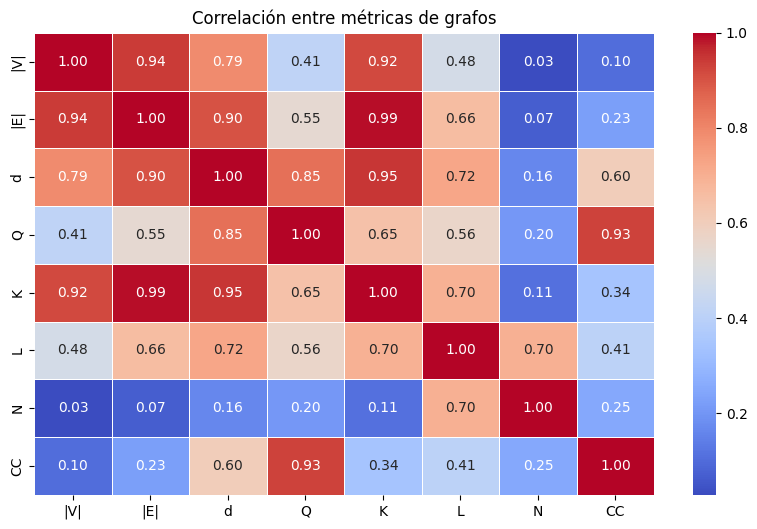

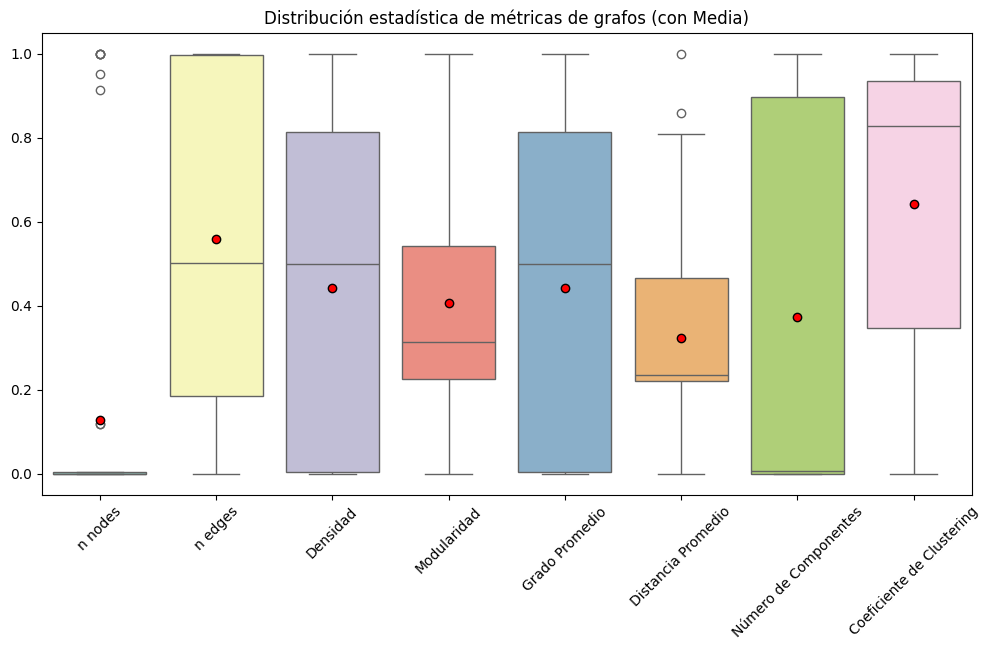

In [140]:
ruta_df = "dfmetrics/DF-M-PMbot.csv"
df = pd.read_csv(ruta_df)

df_final = df.drop(columns=["Grafo","Unnamed: 0"])
df_final.fillna(0, inplace=True)
df_final = df_final.rename(columns={"n nodes":"|V|", "Distancia Promedio": "L",
                                    "Densidad":"d", "Modularidad":"Q",
                                    "Grado Promedio":"K", "n edges":"|E|",
                                    "Número de Componentes":"N",
                                    "Coeficiente de Clustering":"CC"})
### Visualizar la matriz de correlación
# Excluir la columna no numérica ('Grafo') antes de calcular la correlación
correlacion = df_final.corr()
print("\nCorrelación entre métricas:")
print(correlacion)

plt.figure(figsize=(10, 6))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlación entre métricas de grafos")
plt.show()

# Normalizar todas las columnas numéricas al rango [0, 1]
scaler = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler.fit_transform(df_metricas_numericas), 
                               columns=df_metricas_numericas.columns)

# Visualizar estadísticas normalizadas
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_normalizado, palette='Set3', showmeans=True, 
             meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"})
plt.title("Distribución estadística de métricas de grafos (con Media)")
plt.xticks(rotation=45)
plt.show()

In [141]:
count1 = 0
count2 = 0
count3 = 0
for i in correlacion.items():
    for j in i[1]:
        if abs(j) <= 0.1:
            count1+=1
        elif abs(j) > 0.1 and abs(j) <= 0.5:
            count2+=1
        else:
            count3+=1
    print(i[0], "C1=",count1, "\tC2=",count2,"\tC2=",count3)
    count1 = 0
    count2 = 0
    count3 = 0

|V| C1= 1 	C2= 3 	C2= 4
|E| C1= 1 	C2= 1 	C2= 6
d C1= 0 	C2= 1 	C2= 7
Q C1= 0 	C2= 2 	C2= 6
K C1= 0 	C2= 2 	C2= 6
L C1= 0 	C2= 2 	C2= 6
N C1= 2 	C2= 4 	C2= 2
CC C1= 0 	C2= 5 	C2= 3


### Por Dataset


Correlación entre métricas:
          |V|       |E|         d         Q         K         L         N  \
|V|  1.000000  0.485819 -0.200499 -0.176999 -0.194360 -0.239050  0.404682   
|E|  0.485819  1.000000 -0.205378  0.196762 -0.191752  0.363237  0.570525   
d   -0.200499 -0.205378  1.000000 -0.561572  0.999719 -0.379961 -0.588848   
Q   -0.176999  0.196762 -0.561572  1.000000 -0.550702  0.526382  0.678252   
K   -0.194360 -0.191752  0.999719 -0.550702  1.000000 -0.372880 -0.570980   
L   -0.239050  0.363237 -0.379961  0.526382 -0.372880  1.000000  0.443523   
N    0.404682  0.570525 -0.588848  0.678252 -0.570980  0.443523  1.000000   
CC  -0.221142 -0.031149  0.904411 -0.459029  0.907761 -0.222476 -0.473130   

           CC  
|V| -0.221142  
|E| -0.031149  
d    0.904411  
Q   -0.459029  
K    0.907761  
L   -0.222476  
N   -0.473130  
CC   1.000000  


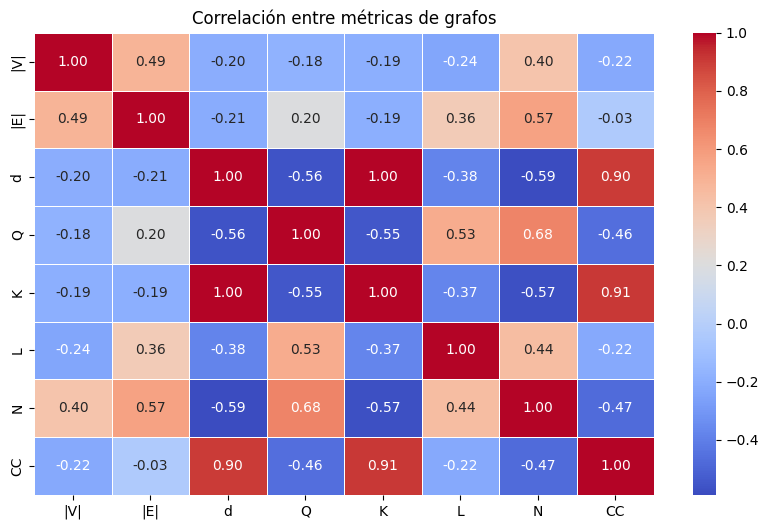

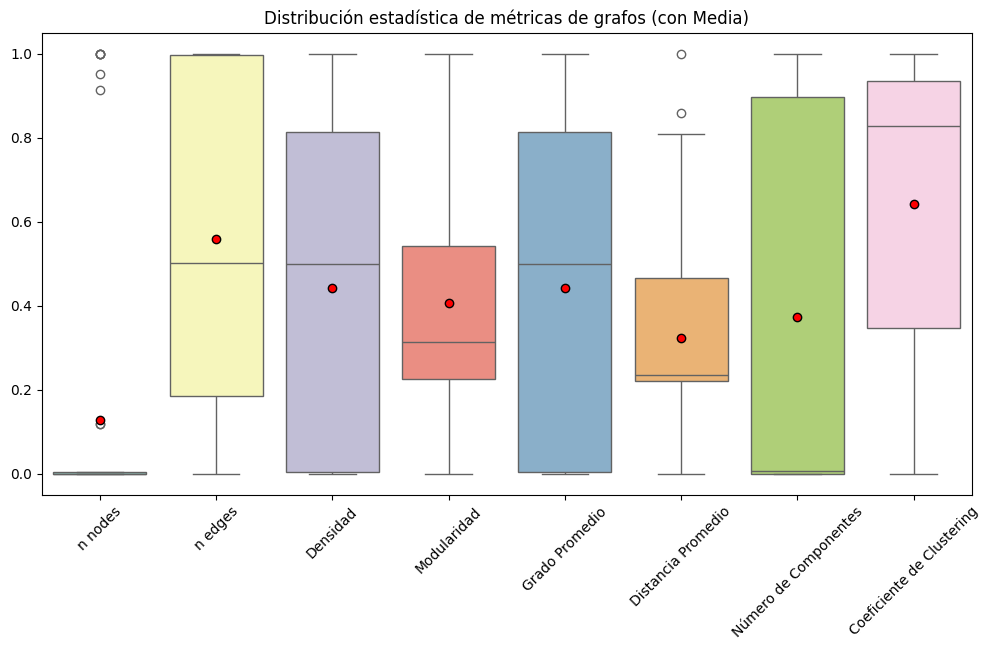

In [142]:
DATASET = "AMZ"
ruta_df = "dfmetrics/DF-M-"+DATASET+"top.csv"
df1 = pd.read_csv(ruta_df)
ruta_df = "dfmetrics/DF-M-"+DATASET+"bot.csv"
df2 = pd.read_csv(ruta_df)

# Paso 2: Concatenar todos los DataFrames en uno solo
df_final = pd.concat([df1, df2], ignore_index=True)
df_final = df_final.drop(columns=["Grafo","Unnamed: 0"])
df_final.fillna(0, inplace=True)
df_final = df_final.rename(columns={"n nodes":"|V|", "Distancia Promedio": "L",
                                    "Densidad":"d", "Modularidad":"Q",
                                    "Grado Promedio":"K", "n edges":"|E|",
                                    "Número de Componentes":"N",
                                    "Coeficiente de Clustering":"CC"})

# Excluir la columna no numérica ('Grafo') antes de calcular la correlación
correlacion = df_final.corr()
print("\nCorrelación entre métricas:")
print(correlacion)

plt.figure(figsize=(10, 6))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlación entre métricas de grafos")
plt.show()

# Normalizar todas las columnas numéricas al rango [0, 1]
scaler = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler.fit_transform(df_metricas_numericas), 
                               columns=df_metricas_numericas.columns)

# Visualizar estadísticas normalizadas
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_normalizado, palette='Set3', showmeans=True, 
             meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"})
plt.title("Distribución estadística de métricas de grafos (con Media)")
plt.xticks(rotation=45)
plt.show()

In [143]:
count1 = 0
count2 = 0
count3 = 0
for i in correlacion.items():
    for j in i[1]:
        if abs(j) <= 0.1:
            count1+=1
        elif abs(j) > 0.1 and abs(j) <= 0.5:
            count2+=1
        else:
            count3+=1
    print(i[0], "C1=",count1, "\tC2=",count2,"\tC2=",count3)
    count1 = 0
    count2 = 0
    count3 = 0

|V| C1= 0 	C2= 7 	C2= 1
|E| C1= 1 	C2= 5 	C2= 2
d C1= 0 	C2= 3 	C2= 5
Q C1= 0 	C2= 3 	C2= 5
K C1= 0 	C2= 3 	C2= 5
L C1= 0 	C2= 6 	C2= 2
N C1= 0 	C2= 3 	C2= 5
CC C1= 1 	C2= 4 	C2= 3


### ALL

In [122]:
# Paso 1: Leer todos los archivos .csv de un directorio
directorio = "dfmetrics/"  # Cambia esto por la ruta de tu directorio
archivos_csv = [archivo for archivo in os.listdir(directorio) if archivo.endswith('.csv')]

# Lista para almacenar los DataFrames
dataframes = []

# Leer cada archivo y almacenarlo en la lista
for archivo in archivos_csv:
    ruta_completa = os.path.join(directorio, archivo)
    df = pd.read_csv(ruta_completa)
    dataframes.append(df)

# Paso 2: Concatenar todos los DataFrames en uno solo
df_final = pd.concat(dataframes, ignore_index=True)
df_final = df_final.drop(columns=["Grafo","Unnamed: 0"])
df_final.fillna(0, inplace=True)
df_final = df_final.rename(columns={"n nodes":"|V|", "Distancia Promedio": "L",
                                    "Densidad":"d", "Modularidad":"Q",
                                    "Grado Promedio":"K", "n edges":"|E|",
                                    "Número de Componentes":"N",
                                    "Coeficiente de Clustering":"CC"})

# Excluir la columna no numérica ('Grafo') antes de calcular la correlación
correlacion = df_final.corr()
print("\nCorrelación entre métricas:")
print(correlacion)


Correlación entre métricas:
          |V|       |E|         d         Q         K         L         N  \
|V|  1.000000  0.452709 -0.163099 -0.030167 -0.084568 -0.063628  0.374813   
|E|  0.452709  1.000000 -0.299301  0.273274  0.109162  0.474000  0.637733   
d   -0.163099 -0.299301  1.000000 -0.079573  0.094272 -0.026939 -0.343047   
Q   -0.030167  0.273274 -0.079573  1.000000  0.018752  0.582089  0.376695   
K   -0.084568  0.109162  0.094272  0.018752  1.000000  0.034861 -0.136968   
L   -0.063628  0.474000 -0.026939  0.582089  0.034861  1.000000  0.496404   
N    0.374813  0.637733 -0.343047  0.376695 -0.136968  0.496404  1.000000   
CC  -0.161977 -0.104514  0.350213  0.254029  0.239240 -0.105275 -0.298502   

           CC  
|V| -0.161977  
|E| -0.104514  
d    0.350213  
Q    0.254029  
K    0.239240  
L   -0.105275  
N   -0.298502  
CC   1.000000  


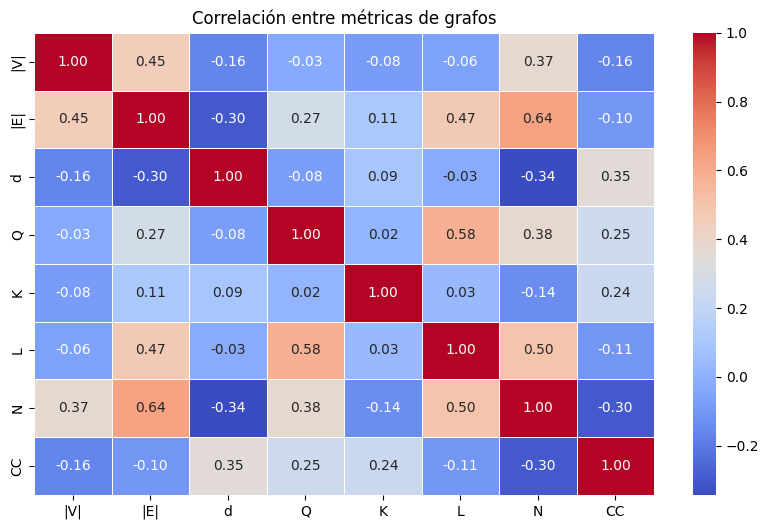

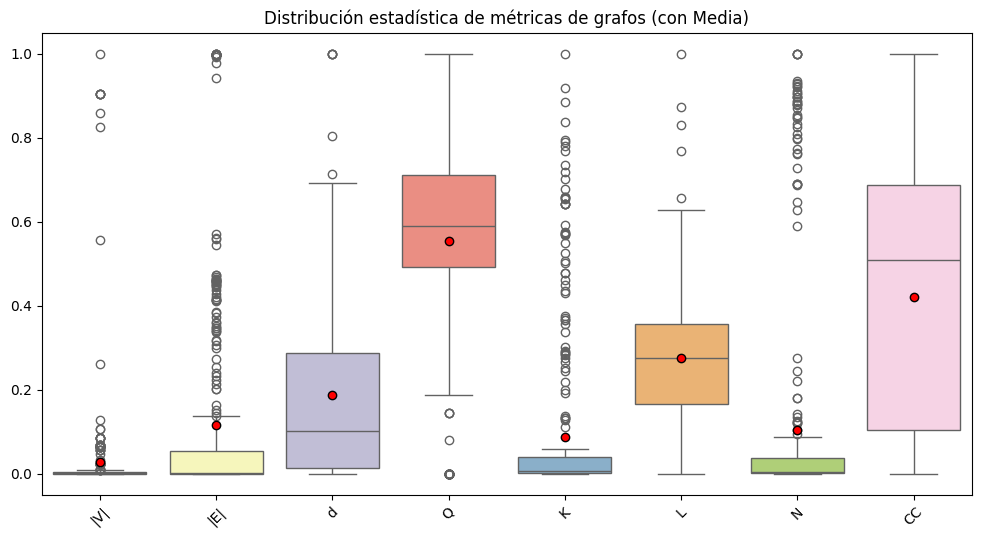

In [123]:
plt.figure(figsize=(10, 6))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlación entre métricas de grafos")
plt.show()

# Normalizar todas las columnas numéricas al rango [0, 1]
scaler = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler.fit_transform(df_final), 
                               columns=df_final.columns)

# Visualizar estadísticas normalizadas
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_normalizado, palette='Set3', showmeans=True, 
             meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "black"})
plt.title("Distribución estadística de métricas de grafos (con Media)")
plt.xticks(rotation=45)
plt.show()

In [124]:
count1 = 0
count2 = 0
count3 = 0
for i in correlacion.items():
    for j in i[1]:
        if abs(j) <= 0.1:
            count1+=1
        elif abs(j) > 0.1 and abs(j) <= 0.5:
            count2+=1
        else:
            count3+=1
    print(i[0], "C1=",count1, "\tC2=",count2,"\tC2=",count3)
    count1 = 0
    count2 = 0
    count3 = 0

|V| C1= 3 	C2= 4 	C2= 1
|E| C1= 0 	C2= 6 	C2= 2
d C1= 3 	C2= 4 	C2= 1
Q C1= 3 	C2= 3 	C2= 2
K C1= 4 	C2= 3 	C2= 1
L C1= 3 	C2= 3 	C2= 2
N C1= 0 	C2= 6 	C2= 2
CC C1= 0 	C2= 7 	C2= 1
